## 2nd level fMRI analysis for simple linear models(for SPM contrast files) in Python
By Willem Huijbers  
1. Setup folder with contrast images (path)
2. Convert hdr/img (3D) and turn into nii (4D)

In [2]:
import os
import glob
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn import plotting
import seaborn
%matplotlib inline

In [6]:
fp_behav = '/Users/huijbers/Dropbox/SideProjects/Project_with_Sander_cueMEM/cuedMEM/cuedMEM_SubjectLevelData.csv' 
data_behav = pd.read_csv(fp_behav)
#WH drop 15-QR, 33-ZK (no fMRI data)
data_behav = data_behav[data_behav.SubjID != '15-QR']  #fix this later in loop
data_behav = data_behav[data_behav.SubjID != '33-ZK']

#fp = os.getcwd()
fp = '/Users/huijbers/Dropbox/SideProjects/student_folder (for Ruben)/fMRI_with_python/'
CONTRAST = 'C_OLD_T_OLD_O_HI_gt_F'

os.chdir(fp + CONTRAST)
fn = glob.glob('*.img') #assumes matching header (hdr) files
nsubjects = len(fn) #n_subjects = 43

In [13]:
list(data_behav)

['SubjID',
 'cue',
 'HI',
 'MI',
 'FA',
 'CR',
 'rt_HI',
 'rt_MI',
 'rt_FA',
 'rt_CR',
 'dprime',
 'bias']

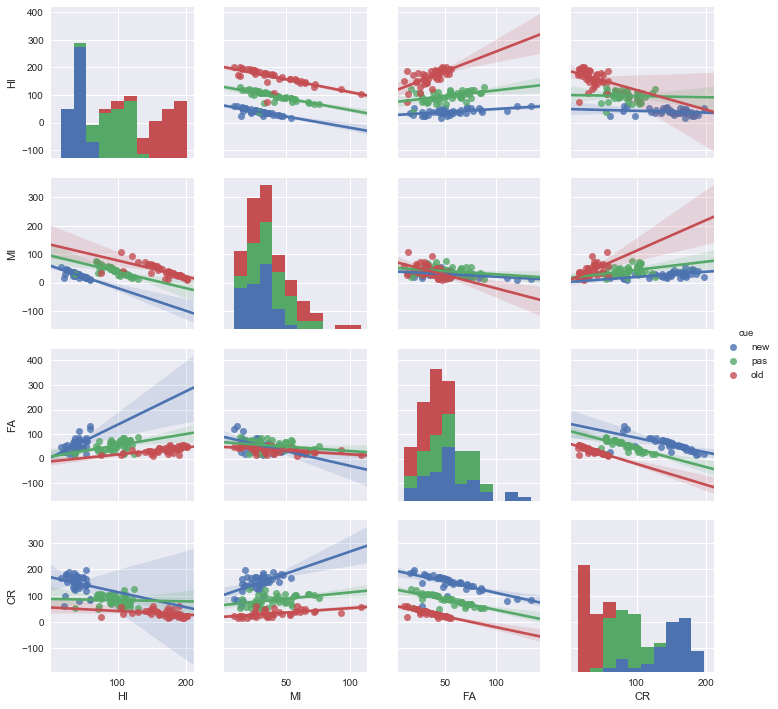

In [22]:
#seaborn.lmplot(y='dprime', x='bias', data=data_behav) 
seaborn.pairplot(data_behav, vars=['HI','MI','FA','CR'], kind='reg', hue='cue')  

In [4]:
#WH put 3D HDR contrast in 4D array
img = nib.load(os.getcwd() + '/' + fn[0])
image_data = img.get_data()
a = list(image_data.shape)
a.append(1) #Need to add emtpy dimensions to append (4d)
image_data.shape = a

#WH loop trough and add matrixes into 4d array
for ii in range(1, len(fn)):  #len(fn)
    img = nib.load(os.getcwd() + '/' + fn[ii])
    temp = img.get_data()
    a = list(temp.shape)
    a.append(1)
    temp.shape = a
    image_data  = np.append(temp , image_data , axis = 3)   
    #print(image_data.shape)
    #print('done loading' + fn[ii])  

image_data.shape

(53, 63, 54, 43)

Mean Image for contrast: C_OLD_T_OLD_O_HI_gt_F


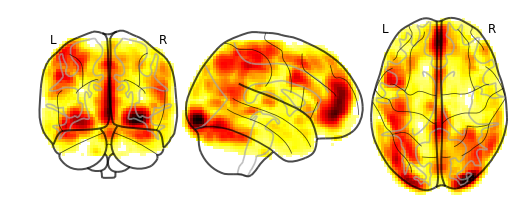

In [5]:
mean_data = np.mean(image_data, axis = 3)
img = nib.load(os.getcwd() + '/' + fn[0])
new_img = nib.Nifti1Image(mean_data, img.affine, img.header)
#nib.save(new_img, 'test.nii')
print('Mean Image for contrast: ' + fn[0][5:len(fn[0])-4]) #show contrast name based on first subject
plotting.plot_glass_brain(new_img)
plotting.show()

Tmap for contrast: C_OLD_T_OLD_O_HI_gt_F


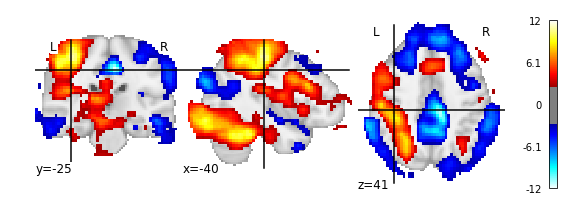

In [6]:
# Calculate a t-map (and visualizes it) --> WH warning is slow (needs a progress bar)
from scipy import stats
n_subjects = image_data[0,0,0,:].shape[0]
vector = np.reshape(image_data,(np.product(image_data.shape[0:3]),n_subjects),order='F')
temp = stats.ttest_1samp(vector[0,:],0)
t = temp.statistic
p = temp.pvalue

for ii in range(1, np.product(image_data.shape[0:3])):  #53*63*54 = 180306 = np.product(image_data.shape[0:3])
    temp = stats.ttest_1samp(vector[ii,:],0)
    t = np.append(t,temp.statistic)
    #p = np.append(p,temp.pvalue)
    
tmap = np.reshape(t,(53,63,54),order='F')
#pmap = np.reshape(p,(53,63,54),order='F')
img = nib.load(os.getcwd() + '/' + fn[0])
new_tmap = nib.Nifti1Image(tmap, img.affine, img.header)
#new_pmap = nib.Nifti1Image(pmap, img.affine, img.header)
#nib.save(new_img, 'test.nii')
print('Tmap for contrast: ' + fn[0][5:len(fn[0])-4]) #show contrast name based on first subject
plotting.plot_stat_map(new_tmap,threshold='auto')
plotting.show()

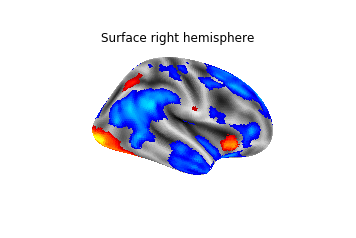

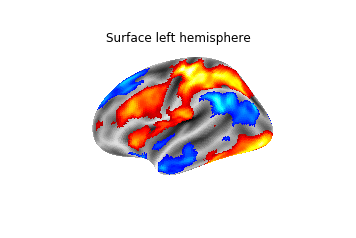

In [9]:
# Plot t-map to surface rendering (from fsaverage)
from nilearn import datasets
fsaverage = datasets.fetch_surf_fsaverage5()
new_tmap = nib.Nifti1Image(np.nan_to_num(tmap), img.affine, img.header)
from nilearn import surface

texture = surface.vol_to_surf(new_tmap, fsaverage.pial_right)
plotting.plot_surf_stat_map(fsaverage.infl_right, texture, hemi='right',
                            title='Surface right hemisphere',
                            threshold=3.0, bg_map=fsaverage.sulc_right,
                            cmap='cold_hot')

texture = surface.vol_to_surf(new_tmap, fsaverage.pial_left)
plotting.plot_surf_stat_map(fsaverage.infl_left, texture, hemi='left',
                            title='Surface left hemisphere',
                            threshold=3.0, bg_map=fsaverage.sulc_left,
                            cmap='cold_hot')
plotting.show()